<a href="https://colab.research.google.com/github/Ahmed-A-Salem/Airbnb_price-category_prediction/blob/main/Airbnb_price%26category_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem formulation

* Input: images and text
* Output: prices and types
* Data mining function: Identifying the best features to train the model
* Challenges: Creating a multimodel with good accuracy in both
* Impact: being able to predict the type and the price of a property using a summary and an image

# Kaggle API

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c cisc-873-dm-f22-a4

 98% 589M/604M [00:04<00:00, 155MB/s]
100% 604M/604M [00:04<00:00, 139MB/s]


In [ ]:
!unzip '/content/cisc-873-dm-f22-a4.zip'

Streaming output truncated to the last 5000 lines.
  inflating: a4/img_train/3366.jpg   
  inflating: a4/img_train/3367.jpg   
  inflating: a4/img_train/3368.jpg   
  inflating: a4/img_train/3369.jpg   
  inflating: a4/img_train/337.jpg    
  inflating: a4/img_train/3370.jpg   
  inflating: a4/img_train/3371.jpg   
  inflating: a4/img_train/3372.jpg   
  inflating: a4/img_train/3373.jpg   
  inflating: a4/img_train/3374.jpg   
  inflating: a4/img_train/3375.jpg   
  inflating: a4/img_train/3376.jpg   
  inflating: a4/img_train/3377.jpg   
  inflating: a4/img_train/3378.jpg   
  inflating: a4/img_train/3379.jpg   
  inflating: a4/img_train/338.jpg    
  inflating: a4/img_train/3380.jpg   
  inflating: a4/img_train/3381.jpg   
  inflating: a4/img_train/3382.jpg   
  inflating: a4/img_train/3383.jpg   
  inflating: a4/img_train/3384.jpg   
  inflating: a4/img_train/3385.jpg   
  inflating: a4/img_train/3386.jpg   
  inflating: a4/img_train/3387.jpg   
  inflating: a4/img_train/3388.jpg   

# Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from ast import literal_eval
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from sklearn.model_selection import train_test_split
from pprint import pprint
from tensorflow.keras.layers import GRU
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Preprocessing

In [ ]:
# Reading the training dataset
df = pd.read_csv('/content/a4/train_xy.csv')
df

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0
...,...,...,...,...
7622,"Un grand logement 4 et 1/2, tout inclut, bien ...",img_train/7626.jpg,Apartment,0
7623,Magnificent condo directly on the river. You w...,img_train/7627.jpg,Apartment,2
7624,This apartment is perfect for anyone visiting ...,img_train/7628.jpg,Apartment,1
7625,"It is a cozy ,clean ,and comfortable apartment...",img_train/7629.jpg,Apartment,0


In [ ]:
# Checking the values of the type output
df['type'].value_counts()

Apartment                 5765
Condominium                691
House                      406
Loft                       324
Townhouse                  167
Serviced apartment          77
Bed and breakfast           38
Guest suite                 32
Hostel                      26
Bungalow                    25
Guesthouse                  14
Cottage                     12
Aparthotel                  12
Boutique hotel              10
Other                        8
Villa                        7
Tiny house                   3
Boat                         2
Cabin                        2
Camper/RV                    2
Casa particular (Cuba)       1
Hotel                        1
Earth house                  1
Castle                       1
Name: type, dtype: int64

In [ ]:
# Checking if the price output is balanced
# Almost 60% of the output belongs to 0 while 2 is the least out present in the dataset
df['price'].value_counts()

0    4737
1    2403
2     487
Name: price, dtype: int64

In [ ]:
# label encoding the type column
df['type'] = df.type.astype('category').cat.codes
# get the total number of unique outputs (later used for prediction)
len_type = len(df['type'].unique())
len_price = len(df['price'].unique())



# split data (training/testing set)
df_train = df 
df_train

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,1,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,1,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,1,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,1,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,1,0
...,...,...,...,...
7622,"Un grand logement 4 et 1/2, tout inclut, bien ...",img_train/7626.jpg,1,0
7623,Magnificent condo directly on the river. You w...,img_train/7627.jpg,1,2
7624,This apartment is perfect for anyone visiting ...,img_train/7628.jpg,1,1
7625,"It is a cozy ,clean ,and comfortable apartment...",img_train/7629.jpg,1,0


In [ ]:
# preprocess image data
i = []

path = '/content/a4/'
def load_image(file):
    global i
    try:
        image = Image.open(path+file).convert('LA').resize((64, 64))
        arr = np.array(image)
    except:
        arr = np.zeros((64, 64, 2))
        # This is to check the name of the images that are corrupted or doesn't exist 
        i.append(file)
    return arr 



# loading images:
x_train_image = np.array([load_image(i) for i in tqdm(df_train.image)])

# loading summary: (force convert some of the non-string cell to string)
x_train_text = df_train.summary.astype('str')

# get type
y_train_type = df_train['type']

# get price
y_train_price = df_train['price']

  0%|          | 0/7627 [00:00<?, ?it/s]

In [ ]:
# Printing the filename of the images that are corrupted
# only 2 files are corrupted so they are replaced by zeroes and can be ignored
i

['img_train/4176.jpg', 'img_train/6083.jpg']

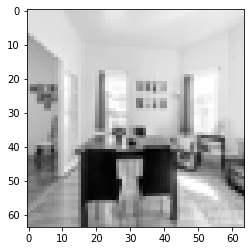

In [ ]:
# Plotting the first image in dataset
plt.imshow(x_train_image[0, :, :, 0],cmap='gray')

In [ ]:
# Printing the values of the images to make sure that they are read correctly
x_train_image

array([[[[226., 255.],
         [226., 255.],
         [226., 255.],
         ...,
         [234., 255.],
         [234., 255.],
         [232., 255.]],

        [[226., 255.],
         [226., 255.],
         [226., 255.],
         ...,
         [232., 255.],
         [231., 255.],
         [230., 255.]],

        [[227., 255.],
         [226., 255.],
         [226., 255.],
         ...,
         [229., 255.],
         [228., 255.],
         [225., 255.]],

        ...,

        [[159., 255.],
         [164., 255.],
         [163., 255.],
         ...,
         [215., 255.],
         [211., 255.],
         [205., 255.]],

        [[157., 255.],
         [155., 255.],
         [149., 255.],
         ...,
         [215., 255.],
         [229., 255.],
         [221., 255.]],

        [[148., 255.],
         [147., 255.],
         [148., 255.],
         ...,
         [201., 255.],
         [206., 255.],
         [214., 255.]]],


       [[[ 67., 255.],
         [ 67., 255.],
         [ 67.

In [ ]:
# setting some parameters for the text preprocessing
vocab_size = 40000
max_len = 100


# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train_text)


def _preprocess(list_of_text):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen=max_len,
        padding='post',
    )
    

# padding is done inside: 
x_train_text_id = _preprocess(x_train_text)

print(x_train_text_id.shape)

(7627, 100)


In [ ]:
pprint(tokenizer.sequences_to_texts(x_train_text_id[:5]))

['spacious sunny and cozy modern apartment in the heart of montreal this 3 '
 'bedroom centrally located in the very popular plateau mont royal '
 'neighborhood in the middle of prince arthur pedestrian only street close to '
 'all amenities restaurants coffee house bars clubs shopping universities '
 'subway stations experience montreal like a real local resident be in the '
 'heart of the action grand prix week grill saint laurent festival mural 2019 '
 'and so much more',
 'located in one of the most vibrant and accessible locations of downtown '
 'montreal this one bedroom condo will not only impress you but leave you with '
 'one of the most memorable experiences it is walking distance of the popular '
 'sainte catherine street the bell center the old port lachine canal '
 'bonaventure metro and much much more',
 'logement coquet et douillet à 10 minutes du centre ville de montréal '
 'épicerie pharmacie saq restaurants et transports en communs à proximité deux '
 'chambres fermée

In [ ]:
print('total words in the dictionary:', tokenizer.num_words)

total words in the dictionary: 40000


# Training

There are 2 different input for the model and 2 different output

## Trial 1

Trying to add 2 LSTM layers while giving equal loss weights for the type and price

In [ ]:
# Here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
# simple average of embedding. you can change it to anything else as needed
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
#averaged = tf.reduce_mean(embedded, axis=1)

lstm = tf.keras.layers.LSTM(84, return_sequences=True)(embedded)
lstm2 = tf.keras.layers.LSTM(42)(lstm)
# lstm2 = tf.keras.layers.LSTM(124, return_sequences=True)(lstm)

# image part 
# simple conv2d. you can change it to anything else as needed
cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)


flattened = Flatten()(pl)


# fusion - combinig both
fused = tf.concat([lstm2, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.5,
        'price': 0.5,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 128, 100)     1400000     ['input_29[0][0]']               
                                                                                                  
 conv2d_19 (Conv2D)             (None, 49, 49, 32)   16416       ['input_30[0][0]']               
                                                                                            

In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=7, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 111s 279ms/step - loss: 20.3621 - price_loss: 17.5838 - type_loss: 23.1403 - price_sparse_categorical_accuracy: 0.5024 - type_sparse_categorical_accuracy: 0.5792 - val_loss: 7.2538 - val_price_loss: 5.4272 - val_type_loss: 9.0804 - val_price_sparse_categorical_accuracy: 0.5033 - val_type_sparse_categorical_accuracy: 0.4777
Epoch 2/20
382/382 [==============================] - 105s 274ms/step - loss: 9.5903 - price_loss: 6.7122 - type_loss: 12.4684 - price_sparse_categorical_accuracy: 0.5073 - type_sparse_categorical_accuracy: 0.5802 - val_loss: 6.6867 - val_price_loss: 6.3348 - val_type_loss: 7.0385 - val_price_sparse_categorical_accuracy: 0.6094 - val_type_sparse_categorical_accuracy: 0.4875
Epoch 3/20
382/382 [==============================] - 105s 276ms/step - loss: 9.0855 - price_loss: 6.9858 - type_loss: 11.1852 - price_sparse_categorical_accuracy: 0.5111 - type_sparse_categorical_accuracy: 0.5853 - val_loss: 9.2727 - val_price


 

*   Train Accuracy: 53%
*   Validation Accuracy: 51%
*   Test Accuracy:  49%
  




## Trial 2

Using 2 lstm layers but assigning more weight for the price loss (0.8)

In [ ]:
# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
# simple average of embedding. you can change it to anything else as needed
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
#averaged = tf.reduce_mean(embedded, axis=1)

lstm = tf.keras.layers.LSTM(84, return_sequences=True)(embedded)
lstm2 = tf.keras.layers.LSTM(42)(lstm)
# lstm2 = tf.keras.layers.LSTM(124, return_sequences=True)(lstm)

# image part 
# simple conv2d. you can change it to anything else as needed
cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)


flattened = Flatten()(pl)


# fusion - combinig both
fused = tf.concat([lstm2, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.2,
        'price': 0.8,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 128, 100)     1400000     ['input_31[0][0]']               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 49, 49, 32)   16416       ['input_32[0][0]']               
                                                                                            

In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=7, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 107s 270ms/step - loss: 17.4615 - price_loss: 16.0520 - type_loss: 23.0998 - price_sparse_categorical_accuracy: 0.4999 - type_sparse_categorical_accuracy: 0.5843 - val_loss: 7.1427 - val_price_loss: 5.4094 - val_type_loss: 14.0760 - val_price_sparse_categorical_accuracy: 0.4574 - val_type_sparse_categorical_accuracy: 0.2058
Epoch 2/20
382/382 [==============================] - 102s 266ms/step - loss: 5.9842 - price_loss: 5.1353 - type_loss: 9.3797 - price_sparse_categorical_accuracy: 0.5171 - type_sparse_categorical_accuracy: 0.5809 - val_loss: 6.0217 - val_price_loss: 5.8141 - val_type_loss: 6.8522 - val_price_sparse_categorical_accuracy: 0.4856 - val_type_sparse_categorical_accuracy: 0.6009
Epoch 3/20
382/382 [==============================] - 102s 266ms/step - loss: 5.9542 - price_loss: 5.3311 - type_loss: 8.4468 - price_sparse_categorical_accuracy: 0.5194 - type_sparse_categorical_accuracy: 0.5796 - val_loss: 5.4910 - val_price_


*   Train Accuracy: 57%
*   Validation Accuracy: 57%
*   Test Accuracy: 59.8%

## Trial 3

Removing the lstm and adding an average layer after the embedding
(the 0.8 weight assigned for the price improved the model so it will be used for the further trials)

In [ ]:
# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
# simple average of embedding. you can change it to anything else as needed
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
averaged = tf.reduce_mean(embedded, axis=1)


# image part 
# simple conv2d. you can change it to anything else as needed
cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)


flattened = Flatten()(pl)


# fusion - combinig both
fused = tf.concat([averaged, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.2,
        'price': 0.8,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 conv2d_22 (Conv2D)             (None, 49, 49, 32)   16416       ['input_36[0][0]']               
                                                                                                  
 embedding_17 (Embedding)       (None, 128, 100)     1400000     ['input_35[0][0]']               
                                                                                           

In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=7, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 60s 154ms/step - loss: 16.6724 - price_loss: 15.6945 - type_loss: 20.5840 - price_sparse_categorical_accuracy: 0.5076 - type_sparse_categorical_accuracy: 0.5771 - val_loss: 5.1841 - val_price_loss: 4.6143 - val_type_loss: 7.4632 - val_price_sparse_categorical_accuracy: 0.5668 - val_type_sparse_categorical_accuracy: 0.6042
Epoch 2/20
382/382 [==============================] - 58s 153ms/step - loss: 5.7364 - price_loss: 4.8707 - type_loss: 9.1993 - price_sparse_categorical_accuracy: 0.5132 - type_sparse_categorical_accuracy: 0.5766 - val_loss: 5.5213 - val_price_loss: 4.9238 - val_type_loss: 7.9115 - val_price_sparse_categorical_accuracy: 0.4875 - val_type_sparse_categorical_accuracy: 0.6225
Epoch 3/20
382/382 [==============================] - 58s 153ms/step - loss: 5.8004 - price_loss: 5.0551 - type_loss: 8.7816 - price_sparse_categorical_accuracy: 0.5243 - type_sparse_categorical_accuracy: 0.5845 - val_loss: 4.9818 - val_price_loss

*   Train Accuracy: 63%
*   Validation Accuracy: 40%
*   Test Accuracy: 43%
* This model seems to be overfitting

## Trial 4

Using biderctional lstm and gru

In [ ]:
# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
# simple average of embedding. you can change it to anything else as needed
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
bi_lstm = Bidirectional(GRU(20, return_sequences=True , recurrent_regularizer='l2'))(embedded)
bi_lstm2 = Bidirectional(GRU(20, recurrent_regularizer='l2'))(bi_lstm)
averaged = tf.reduce_mean(embedded, axis=1)


# image part 
# simple conv2d. you can change it to anything else as needed
cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)


flattened = Flatten()(pl)


# fusion - combinig both
fused = tf.concat([bi_lstm2, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.2,
        'price': 0.8,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 128, 100)     1400000     ['input_39[0][0]']               
                                                                                                  
 conv2d_23 (Conv2D)             (None, 49, 49, 32)   16416       ['input_40[0][0]']               
                                                                                           

In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=7, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 130s 318ms/step - loss: 22.3385 - price_loss: 21.0399 - type_loss: 26.6841 - price_sparse_categorical_accuracy: 0.4980 - type_sparse_categorical_accuracy: 0.5673 - val_loss: 11.0909 - val_price_loss: 10.2080 - val_type_loss: 14.5839 - val_price_sparse_categorical_accuracy: 0.4954 - val_type_sparse_categorical_accuracy: 0.5472
Epoch 2/20
382/382 [==============================] - 120s 314ms/step - loss: 6.1637 - price_loss: 5.4022 - type_loss: 9.2013 - price_sparse_categorical_accuracy: 0.5109 - type_sparse_categorical_accuracy: 0.5794 - val_loss: 5.7831 - val_price_loss: 5.6620 - val_type_loss: 6.2670 - val_price_sparse_categorical_accuracy: 0.5642 - val_type_sparse_categorical_accuracy: 0.6520
Epoch 3/20
382/382 [==============================] - 120s 314ms/step - loss: 5.5442 - price_loss: 4.9960 - type_loss: 7.7369 - price_sparse_categorical_accuracy: 0.5158 - type_sparse_categorical_accuracy: 0.5740 - val_loss: 5.1010 - val_pric

*   Train Accuracy: 60%
*   Validation Accuracy: 59%
*   Test Accuracy: 59.2%
* This model is the second best model

## Trial 5

Using only 1 lstm layer and adding cov layers and dropout layers

In [ ]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2)) 

embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)

lstm = LSTM(50)(embedded)
#den1 = Dense(128,activation= "relu")(lstm)



cov = Conv2D(64, (3, 3))(in_image) # convolutional layer with 32 filters, and a 16x16 mask
drop = Dropout(0.3)(cov) # 20% dropout
pl = MaxPool2D((3, 3))(drop) # max pooling with a 3x3 mask
cov2 = Conv2D(32, (2,2))(pl) # convolutional layer with 32 filters and a 2x2 mask
drop2 = Dropout(0.3)(cov2) # 20% dropout
pl2 = MaxPool2D((2,2))(drop2) # max pooling with a 2x2 mask
flattened = Flatten()(pl2)
den2 = Dense(100,activation= "softmax")(flattened)
# drop2 = Dropout(0.3)(den2)

# fusion:
fused = tf.concat([den2, lstm], axis=-1) 

# multi-objectives
p_price = Dense(len_price, activation='softmax', name='price')(fused) # predict price label 
p_type = Dense(len_type, activation='softmax', name='type')(fused) # predict rental category


lstm_model = keras.Model(
    inputs={
        'summary': in_text, # text inputs
        'image': in_image # image inputs
    },
    outputs={
        'price': p_price, # label 1: price category (0, 1, or 2)
        'type': p_type, # label 2: type category [0-23]
    },
)

lstm_model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.2,
        'price': 0.8,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 128, 100)     1400000     ['input_39[0][0]']               
                                                                                                  
 conv2d_23 (Conv2D)             (None, 49, 49, 32)   16416       ['input_40[0][0]']               
                                                                                           

In [ ]:
history = lstm_model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 70s 176ms/step - loss: 0.9097 - price_loss: 0.8480 - type_loss: 1.1563 - price_sparse_categorical_accuracy: 0.6135 - type_sparse_categorical_accuracy: 0.7318 - val_loss: 0.8609 - val_price_loss: 0.8330 - val_type_loss: 0.9726 - val_price_sparse_categorical_accuracy: 0.6252 - val_type_sparse_categorical_accuracy: 0.7647
Epoch 2/20
382/382 [==============================] - 65s 170ms/step - loss: 0.8748 - price_loss: 0.8387 - type_loss: 1.0195 - price_sparse_categorical_accuracy: 0.6201 - type_sparse_categorical_accuracy: 0.7536 - val_loss: 0.8596 - val_price_loss: 0.8312 - val_type_loss: 0.9732 - val_price_sparse_categorical_accuracy: 0.6252 - val_type_sparse_categorical_accuracy: 0.7647
Epoch 3/20
382/382 [==============================] - 66s 173ms/step - loss: 0.8744 - price_loss: 0.8384 - type_loss: 1.0187 - price_sparse_categorical_accuracy: 0.6201 - type_sparse_categorical_accuracy: 0.7536 - val_loss: 0.8614 - val_price_loss: 0

*   Train Accuracy: 62%
*   Validation Accuracy: 62%
*   Test Accuracy: 45%

## Trial 6

Adding spatial dropout and lstm dropout hoping that the learning might get better

In [ ]:
# here we have two inputs. one for image and the other for text.
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 64, 64, 2))

# text part
# simple average of embedding. you can change it to anything else as needed
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
drp = SpatialDropout1D(0.2)(embedded)
lstm = tf.keras.layers.LSTM(84, dropout=0.2)(drp)
#averaged = tf.reduce_mean(embedded, axis=1)

# lstm = tf.keras.layers.LSTM(84, return_sequences=True)(embedded)
# lstm2 = tf.keras.layers.LSTM(42)(lstm)
# lstm2 = tf.keras.layers.LSTM(124, return_sequences=True)(lstm)

# image part 
# simple conv2d. you can change it to anything else as needed
cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)


flattened = Flatten()(pl)


# fusion - combinig both
fused = tf.concat([lstm, flattened], axis=-1)

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_type = Dense(len_type, activation='softmax', name='type')(fused)
p_price = Dense(len_price, activation='softmax', name='price')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'summary': in_text,
        'image': in_image
    },
    outputs={
        'type': p_type,
        'price': p_price,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'type': 'sparse_categorical_crossentropy',
        'price': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'type': 0.2,
        'price': 0.8,       
    },
    metrics={
        'type': ['SparseCategoricalAccuracy'],
        'price': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     4000000     ['input_3[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 49, 49, 32)   16416       ['input_4[0][0]']                
                                                                                              

In [ ]:
history = model.fit(
    x={
        'summary': x_train_text_id,
        'image': x_train_image
    },
    y={
        'type': y_train_type,
        'price': y_train_price,
    },
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, )
    ],
    verbose=1
)

Epoch 1/20
382/382 [==============================] - 110s 270ms/step - loss: 16.4973 - price_loss: 16.0637 - type_loss: 18.2318 - price_sparse_categorical_accuracy: 0.4953 - type_sparse_categorical_accuracy: 0.5835 - val_loss: 5.1049 - val_price_loss: 4.6687 - val_type_loss: 6.8495 - val_price_sparse_categorical_accuracy: 0.5125 - val_type_sparse_categorical_accuracy: 0.6815
Epoch 2/20
382/382 [==============================] - 95s 249ms/step - loss: 5.5518 - price_loss: 5.0480 - type_loss: 7.5673 - price_sparse_categorical_accuracy: 0.5058 - type_sparse_categorical_accuracy: 0.5852 - val_loss: 6.3429 - val_price_loss: 6.0825 - val_type_loss: 7.3842 - val_price_sparse_categorical_accuracy: 0.4266 - val_type_sparse_categorical_accuracy: 0.7051
Epoch 3/20
382/382 [==============================] - 95s 249ms/step - loss: 5.3418 - price_loss: 4.8687 - type_loss: 7.2341 - price_sparse_categorical_accuracy: 0.5206 - type_sparse_categorical_accuracy: 0.5883 - val_loss: 7.6727 - val_price_los

*   Train Accuracy: 64%
*   Validation Accuracy: 59%
*   Test Accuracy: 55%
*   Good model but there is better

# Testing

In [ ]:
# Reading test dataset
df_test = pd.read_csv('/content/a4/test_x.csv')

df_test['type'] = df.type.astype('category').cat.codes

# loading images:
x_test_image = np.array([load_image(i) for i in tqdm(df_test.image)])

  0%|          | 0/7360 [00:00<?, ?it/s]

In [ ]:
# loading summary: (force convert some of the non-string cell to string)
x_test_text = df_test.summary.astype('str')

x_test_text_id = _preprocess(x_test_text)

In [ ]:
y_predict = model.predict(
    {
        'summary': x_test_text_id,
        'image': x_test_image
    }
)


# probabilities
price_predicted = y_predict['price']
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)

[[9.5421219e-01 4.5753244e-02 3.4597557e-05]
 [8.9962065e-01 1.0037328e-01 6.1633177e-06]
 [9.7424215e-01 2.4507981e-02 1.2498957e-03]
 ...
 [5.4996867e-02 9.4499826e-01 4.8826223e-06]
 [9.5479792e-01 4.3629538e-02 1.5725517e-03]
 [9.9817824e-01 1.8217119e-03 3.5623035e-10]]
[0 0 0 ... 1 0 0]


In [ ]:
# # Kaggle submission
# pd.DataFrame(
#     {'id': df_test.id,
#      'price': price_category_predicted}
# ).to_csv('sample_submission.csv', index=False)